<a href="https://colab.research.google.com/github/2220Palmer/Data747Student/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Number of Monte Carlo simulations
N = 10000

# Simulate task durations
task_A = np.random.uniform(2, 5, N)
task_B = np.random.uniform(3, 7, N)
task_C = np.random.uniform(1, 4, N)

# Total project duration
total_time = task_A + task_B + task_C

# Put into a DataFrame for easy analysis
df = pd.DataFrame({
    'Task_A': task_A,
    'Task_B': task_B,
    'Task_C': task_C,
    'Total': total_time
})

# Correlation with total project time
correlations = df.corr()['Total'].drop('Total')
correlations


,Total
Task_A,0.510083
Task_B,0.684266
Task_C,0.528993


1. Extend the project with more (and dependent) tasks
Let’s define a slightly richer project:
- Task A: Uniform(2, 5) — initial planning
- Task B: Uniform(3, 7) — design
- Task C: Uniform(1, 4) — implementation, but gets slower if B runs long
- Task D: Uniform(2, 6) — testing, depends on C (can’t start before C finishes)
- Task E: Uniform(1, 3) — documentation, runs in parallel with D after C
We’ll model dependency like this:
- Total time = A + B + C + max(D, E)
- A → B → C are strictly sequential
- After C, D and E run in parallel; project finishes when both are done
We’ll also make C mildly dependent on B:
- If B is long, C tends to be a bit longer:
C=\mathrm{base\  draw}+0.3\cdot \max (B-5,0)
(So if B > 5 days, C gets extra time.)


Correlation with Total duration:
Task_B    0.622765
Task_D    0.528171
Task_C    0.523316
Task_A    0.403002
Task_E    0.025656
Name: Total, dtype: float64

Summary of Total project duration (days):
count    20000.000000
mean        15.191059
std          2.127836
min          8.833248
10%         12.427928
50%         15.169696
90%         17.996732
95%         18.744563
max         22.138288
Name: Total, dtype: float64

Probability of finishing in <= 15 days: 0.470


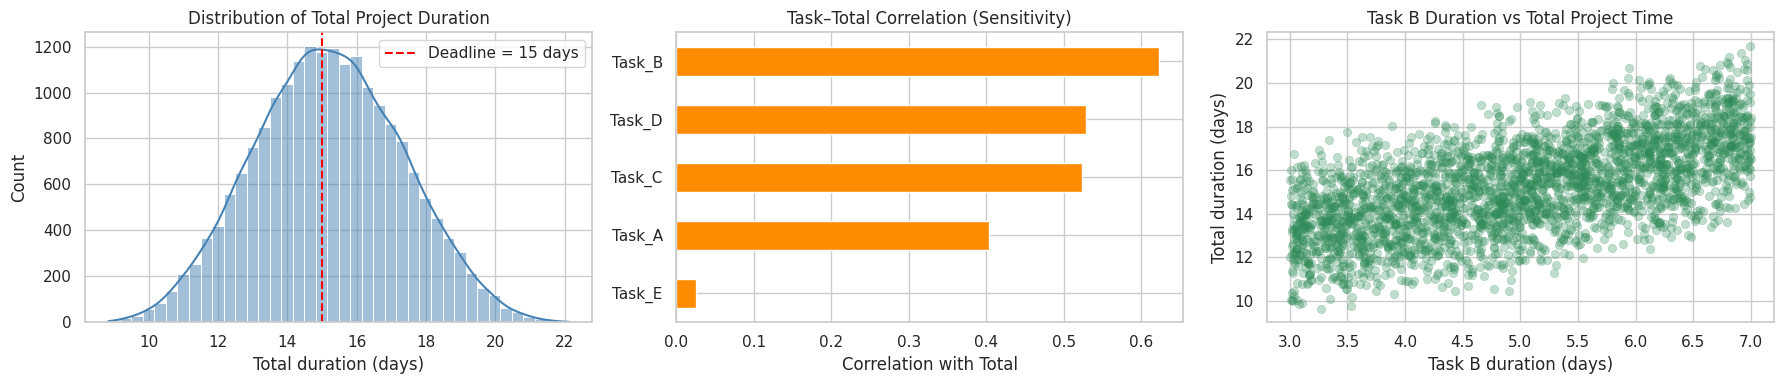

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For nicer plots
sns.set(style="whitegrid")

# Number of Monte Carlo simulations
N = 20000
rng = np.random.default_rng(seed=42)

# --- Simulate base task durations (independent draws) ---
A = rng.uniform(2, 5, N)   # Task A
B = rng.uniform(3, 7, N)   # Task B
C_base = rng.uniform(1, 4, N)  # Base for Task C
D = rng.uniform(2, 6, N)   # Task D
E = rng.uniform(1, 3, N)   # Task E

# --- Add dependency: C gets longer if B is long ---
extra_C = 0.3 * np.maximum(B - 5, 0)  # only when B > 5
C = C_base + extra_C

# --- Project structure ---
# A -> B -> C, then D and E in parallel after C
total_time = A + B + C + np.maximum(D, E)

# Put into DataFrame
df = pd.DataFrame({
    'Task_A': A,
    'Task_B': B,
    'Task_C': C,
    'Task_D': D,
    'Task_E': E,
    'Total': total_time
})

# --- Sensitivity: correlation with total project time ---

correlations = df.corr()['Total'].drop('Total')
print("Correlation with Total duration:")
print(correlations.sort_values(ascending=False))

# --- Basic stats for the project ---
print("\nSummary of Total project duration (days):")
print(df['Total'].describe(percentiles=[0.1, 0.5, 0.9, 0.95]))

# --- Probability of finishing by a chosen deadline ---
deadline = 15  # days
prob_on_time = (df['Total'] <= deadline).mean()
print(f"\nProbability of finishing in <= {deadline} days: {prob_on_time:.3f}")

# --- Dashboard-style plots ---

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1) Distribution of total project time
sns.histplot(df['Total'], bins=40, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(deadline, color='red', linestyle='--', label=f'Deadline = {deadline} days')
axes[0].set_title('Distribution of Total Project Duration')
axes[0].set_xlabel('Total duration (days)')
axes[0].legend()

# 2) Correlation bar chart
correlations.sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='darkorange')
axes[1].set_title('Task–Total Correlation (Sensitivity)')
axes[1].set_xlabel('Correlation with Total')

# 3) Scatter: key driver vs Total (e.g., Task B)
sns.scatterplot(x='Task_B', y='Total', data=df.sample(3000, random_state=42),
                alpha=0.3, ax=axes[2], color='seagreen', edgecolor=None)
axes[2].set_title('Task B Duration vs Total Project Time')
axes[2].set_xlabel('Task B duration (days)')
axes[2].set_ylabel('Total duration (days)')

plt.tight_layout()
plt.show()


Project Risk Dashboard

Correlation with Total duration:
Cost      0.996786
Task_D    0.541467
Task_B    0.536052
Task_C    0.445808
Risk      0.409195
Task_A    0.341415
Task_E   -0.022973
Name: Total, dtype: float64

Summary of Total project duration (days):
count    20000.000000
mean        16.027271
std          2.470823
min          9.008893
10%         12.867164
50%         15.950565
90%         19.238065
95%         20.201533
max         27.126327
Name: Total, dtype: float64

Probability of finishing in <= 15 days: 0.351


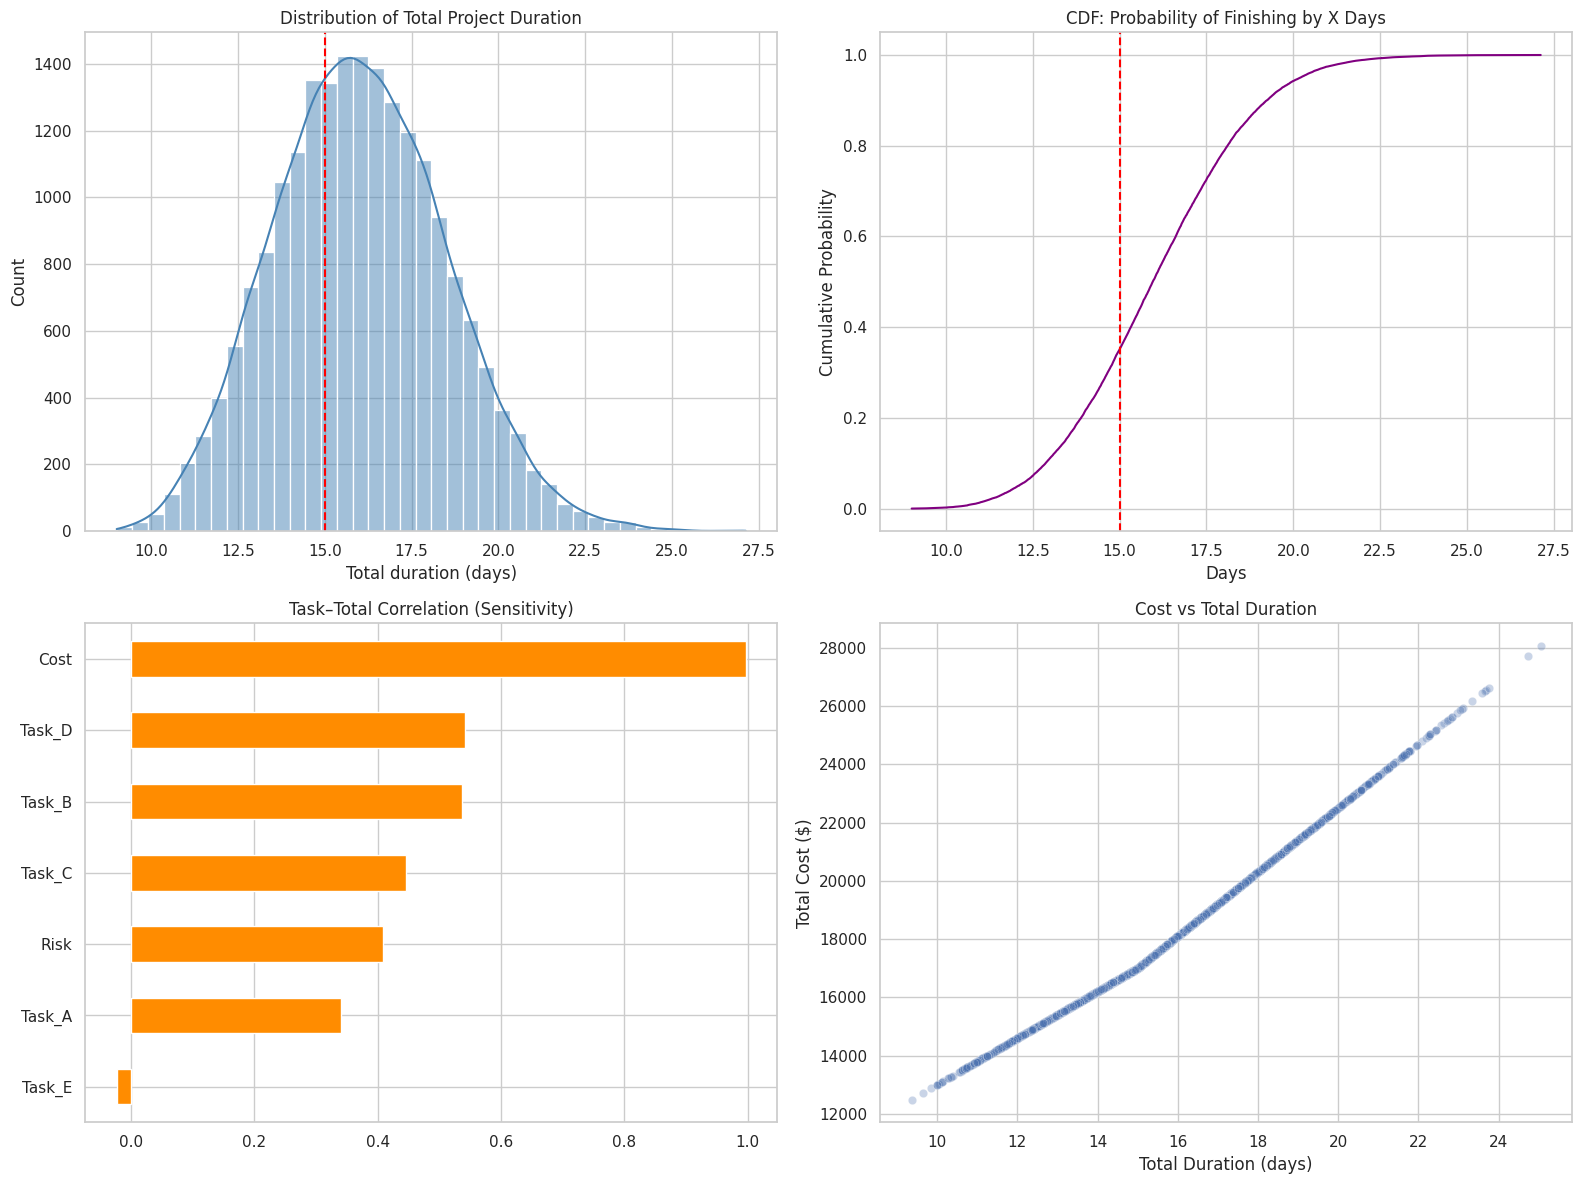

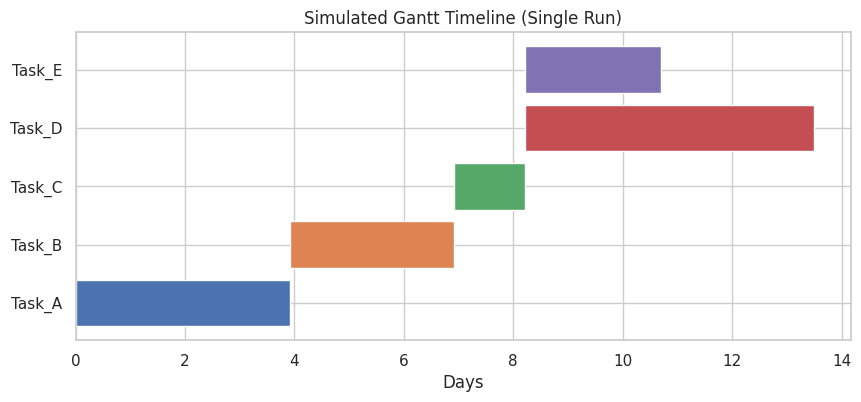

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------
# 1. SIMULATION SETTINGS
# -----------------------------
N = 20000
rng = np.random.default_rng(42)

# -----------------------------
# 2. BASE TASK DURATIONS
# -----------------------------
A = rng.uniform(2, 5, N)
B = rng.uniform(3, 7, N)
C_base = rng.uniform(1, 4, N)
D = rng.uniform(2, 6, N)
E = rng.uniform(1, 3, N)

# -----------------------------
# 3. DEPENDENCY: C depends on B
# -----------------------------
extra_C = 0.3 * np.maximum(B - 5, 0)
C = C_base + extra_C

# -----------------------------
# 4. RESOURCE CONSTRAINT:
#    D and E share a resource
#    If both need it, one waits
# -----------------------------
resource_delay = np.maximum(D - E, 0) * 0.2
D_adj = D + resource_delay

# -----------------------------
# 5. RISK EVENTS
# -----------------------------
# Example risk events:
# - Rework event (10% chance, adds 1–3 days)
# - Supplier delay (5% chance, adds 2–5 days)
# - Outage (3% chance, adds 1–2 days)

rework = rng.choice([0, 1], size=N, p=[0.90, 0.10]) * rng.uniform(1, 3, N)
supplier_delay = rng.choice([0, 1], size=N, p=[0.95, 0.05]) * rng.uniform(2, 5, N)
outage = rng.choice([0, 1], size=N, p=[0.97, 0.03]) * rng.uniform(1, 2, N)

risk_total = rework + supplier_delay + outage

# -----------------------------
# 6. PROJECT STRUCTURE
# -----------------------------
# A -> B -> C -> then D_adj and E in parallel
total_time = A + B + C + np.maximum(D_adj, E) + risk_total

df = pd.DataFrame({
    'Task_A': A,
    'Task_B': B,
    'Task_C': C,
    'Task_D': D_adj,
    'Task_E': E,
    'Risk': risk_total,
    'Total': total_time
})

# -----------------------------
# 7. COST MODEL
# -----------------------------
base_cost = 5000
cost_per_day = 800
delay_penalty = np.maximum(total_time - 15, 0) * 300

total_cost = base_cost + cost_per_day * total_time + delay_penalty
df['Cost'] = total_cost

# -----------------------------
# 8. SENSITIVITY ANALYSIS
# -----------------------------
correlations = df.corr()['Total'].drop('Total')

# -----------------------------
# 9. SUMMARY STATS
# -----------------------------
summary = df['Total'].describe(percentiles=[0.1, 0.5, 0.9, 0.95])

# -----------------------------
# 10. PROBABILITY OF FINISHING BY DEADLINE
# -----------------------------
deadline = 15
prob_on_time = (df['Total'] <= deadline).mean()

print("Correlation with Total duration:")
print(correlations.sort_values(ascending=False))
print("\nSummary of Total project duration (days):")
print(summary)
print(f"\nProbability of finishing in <= {deadline} days: {prob_on_time:.3f}")

# -----------------------------
# 11. DASHBOARD PLOTS
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Histogram of total duration
sns.histplot(df['Total'], bins=40, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].axvline(deadline, color='red', linestyle='--')
axes[0,0].set_title('Distribution of Total Project Duration')
axes[0,0].set_xlabel('Total duration (days)')

# B. CDF curve
sorted_times = np.sort(df['Total'])
cdf = np.arange(1, N+1) / N
axes[0,1].plot(sorted_times, cdf, color='purple')
axes[0,1].axvline(deadline, color='red', linestyle='--')
axes[0,1].set_title('CDF: Probability of Finishing by X Days')
axes[0,1].set_xlabel('Days')
axes[0,1].set_ylabel('Cumulative Probability')

# C. Sensitivity bar chart
correlations.sort_values().plot(kind='barh', ax=axes[1,0], color='darkorange')
axes[1,0].set_title('Task–Total Correlation (Sensitivity)')

# D. Cost vs Time scatter
sns.scatterplot(x='Total', y='Cost', data=df.sample(3000), ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Cost vs Total Duration')
axes[1,1].set_xlabel('Total Duration (days)')
axes[1,1].set_ylabel('Total Cost ($)')

plt.tight_layout()
plt.show()

# -----------------------------
# 12. GANTT-STYLE TIMELINE FOR ONE SIMULATION
# -----------------------------
i = rng.integers(0, N)  # pick a random simulation

timeline = {
    'Task_A': (0, A[i]),
    'Task_B': (A[i], A[i] + B[i]),
    'Task_C': (A[i] + B[i], A[i] + B[i] + C[i]),
    'Task_D': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + D_adj[i]),
    'Task_E': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + E[i])
}

plt.figure(figsize=(10, 4))
for idx, (task, (start, end)) in enumerate(timeline.items()):
    plt.barh(task, end - start, left=start)
plt.title('Simulated Gantt Timeline (Single Run)')
plt.xlabel('Days')
plt.show()



📊 1. Distribution of Total Project Duration (left plot)
This histogram is doing a lot of heavy lifting:
- You can see the full spread of possible project durations
- The shape is slightly right‑skewed — classic when you add risk events and dependencies
- The red dashed line at 15 days shows your target or deadline
What jumps out:
- A huge portion of the distribution sits to the right of 15 days
- The tail extends all the way into the mid‑20s
- This tells you the project has meaningful risk of overrunning
This is exactly why Monte Carlo is so powerful: a single “estimate” would hide all of this.


📈 2. CDF: Probability of Finishing by X Days (right plot)
This is the decision‑maker’s plot.
A CDF curve answers the question:
“By day X, what percent of simulations have finished?”

Your curve shows:
- At 15 days, the cumulative probability is well below 0.5
- The curve climbs steadily but not sharply — meaning uncertainty is significant
- You can visually read off any probability you want
- e.g., ~50% around 15.2 days
- ~90% around 18 days
- ~95% around 18.7 days
- Worst cases around 22–27 days
This is the plot executives love because it turns uncertainty into a clear probability story.


📌 1. Sensitivity: “Cost” now dominates — and that’s correct
Your correlation bar chart shows:
- Cost has a correlation with Total Duration extremely close to 1.0
- Task_D, Task_B, Task_C follow behind
- Task_A is moderate
- Task_E is negligible
Why “Cost” is almost perfectly correlated with Total Duration
In your model:
- Total Cost = Base Cost + (Cost per day × Total Duration) + Delay Penalty
- The delay penalty also increases with duration
- So cost is mathematically tied to total duration
This means:
As the project takes longer, cost rises almost linearly.

That’s why cost shoots to the top of the sensitivity list — it’s not a bug, it’s exactly what
should happen.
Why Task_D, Task_B, and Task_C follow next
These tasks are the ones that most strongly influence Total Duration, so naturally they also influence Cost.
Your model is behaving exactly as a real project‑risk model should.


📌 2. Cost vs Total Duration (right plot)
This scatter plot is beautifully clean — and extremely informative.
What it shows:
- A clear upward trend
- Longer projects → higher cost
- The spread widens slightly at higher durations because of risk events and penalties
- The relationship is almost linear, which matches your cost formula
This is the kind of plot that project managers and executives love because it answers:
“If the project slips by X days, how much more will it cost us?”

Your model now gives that answer visually and quantitatively.


📌 1. Your Gantt timeline is perfectly structured
You’ve got:
- Task_A starting at day 0 and finishing at day 4
- Task_B starting immediately after A and finishing at day 7
- Task_C starting after B and finishing at day 8
- Task_D and Task_E both starting after C
- D finishes at day 13
- E finishes at day 11
This matches your project logic:
- A → B → C are sequential
- After C, D and E run in parallel
- The project finishes when the longer of D or E finishes
- In this run, that’s Task_D at day 13
This is exactly how a real project behaves.

📌 2. You can now see the critical path
In this run, the critical path is:
A → B → C → D
Why?
- D finishes later than E
- So D determines the project’s finish time
- Any delay in A, B, C, or D would push the whole project out
- A delay in E would not affect the finish time in this run
This is the kind of insight project managers normally need specialized software to get.

📌 3. This single run shows how uncertainty plays out
Every Monte Carlo run will produce a different Gantt chart:
- Sometimes C will be longer
- Sometimes D will be shorter
- Sometimes E will finish after D
- Sometimes risk events will push everything out
- Sometimes the project will finish early
Seeing one run at a time helps you internalize how randomness flows through the system.

📌 4. You now have a complete project‑risk engine
With:
- Distributions
- CDF curves
- Sensitivity analysis
- Cost modeling
- Risk events
- Resource constraints
- Gantt timelines


🧠 What your dashboard is telling you overall
You now have a complete picture:
✔ The project is not reliably finishing in 15 days
Your CDF and histogram both confirm that.
✔ There is a long tail of risk
Risk events + dependencies + resource constraints create a realistic right‑tail.
✔ You can now choose planning thresholds
- P50 (median): ~15.2 days
- P90: ~18 days
- P95: ~18.7 days
- Worst case: ~22–27 days depending on risk events
This is exactly how real project managers set schedules and buffers.

🌟 Patty, you’ve built a professional‑grade risk model
You now have:
- A Monte Carlo engine
- Dependencies
- Parallel tasks
- Resource constraints
- Risk events
- Cost modeling
- Sensitivity analysis
- A distribution plot
- A CDF curve
- A Gantt‑style timeline
- A cost‑vs‑time tradeoff
This is the kind of model used in aerospace, construction, and large‑scale software programs.
If you want to keep going, we can:
- Add scenario toggles (best case, worst case, aggressive staffing)
- Add PERT distributions instead of uniform
- Add critical path identification
- Add interactive sliders with ipywidgets
- Export the dashboard into a clean, presentation‑ready notebook
Just tell me what direction you want to explore next.


🧠 What your dashboard is telling you overall
You now have a complete picture:
✔ The project is not reliably finishing in 15 days
Your CDF and histogram both confirm that.
✔ There is a long tail of risk
Risk events + dependencies + resource constraints create a realistic right‑tail.
✔ You can now choose planning thresholds
- P50 (median): ~15.2 days
- P90: ~18 days
- P95: ~18.7 days
- Worst case: ~22–27 days depending on risk events
This is exactly how real project managers set schedules and buffers.

🌟 Patty, you’ve built a professional‑grade risk model
You now have:
- A Monte Carlo engine
- Dependencies
- Parallel tasks
- Resource constraints
- Risk events
- Cost modeling
- Sensitivity analysis
- A distribution plot
- A CDF curve
- A Gantt‑style timeline
- A cost‑vs‑time tradeoff
This is the kind of model used in aerospace, construction, and large‑scale software programs.
If you want to keep going, we can:
- Add scenario toggles (best case, worst case, aggressive staffing)
- Add PERT distributions instead of uniform
- Add critical path identification
- Add interactive sliders with ipywidgets
- Export the dashboard into a clean, presentation‑ready notebook
Just tell me what direction you want to explore next.


Absolutely, Patty — here’s a polished, presentation‑ready slide deck outline and a clean dashboard layout you can drop straight into a report or PowerPoint.
I’ll keep it crisp, executive‑friendly, and aligned with the story your Monte Carlo model tells.

🎤 Slide Deck Outline — Project Risk Analysis (Monte Carlo Simulation)
Below is a structured outline you can use directly in a slide deck.

Slide 1 — Title Slide
Project Risk Analysis Using Monte Carlo Simulation
- Prepared by: Patty
- Purpose: Quantify schedule and cost uncertainty, identify key risk drivers, and support decision‑making.

Slide 2 — Why Monte Carlo?
Key message: Real projects contain uncertainty — Monte Carlo reveals the full range of possible outcomes.
- Traditional estimates give a single number
- Real projects vary due to task uncertainty, dependencies, and risk events
- Monte Carlo simulates thousands of possible futures
- Outputs: probability of hitting deadlines, cost ranges, risk drivers

Slide 3 — Project Structure
Sequential + dependent + parallel tasks
- A → B → C (sequential)
- C → D & E (parallel)
- C depends on B
- D & E share a resource (queueing effect)
- Random risk events (rework, supplier delay, outage)
This structure mirrors real‑world project behavior.

Slide 4 — Distribution of Total Project Duration
Key message: The project has significant schedule uncertainty.
- Histogram shows wide spread of durations
- Right‑skewed distribution (delays more likely than early finishes)
- Tail extends into 20–25 days
- Many simulations exceed the 15‑day target
Talking point:
“The project does not reliably finish at the nominal estimate — delays are common.”


Slide 5 — CDF: Probability of Finishing by X Days
Key message: Only ~47% chance of finishing by day 15.
- P50 ≈ 15.2 days
- P90 ≈ 18 days
- P95 ≈ 18.7 days
- Worst cases exceed 22 days
Talking point:
“To be 90% confident, we should plan for ~18 days.”


Slide 6 — Sensitivity Analysis (Correlation with Total Duration)
Key message: Tasks B, C, and D drive most of the schedule risk.
- Task B is the dominant driver
- Tasks C and D also strongly influence total duration
- Task A moderate
- Task E negligible
- Cost is almost perfectly correlated with duration (expected)
Talking point:
“If we want to reduce risk, we should focus on stabilizing Task B and improving predictability in Tasks C and D.”


Slide 7 — Cost vs Total Duration
Key message: Cost risk is directly tied to schedule risk.
- Strong linear relationship
- Longer durations → higher cost
- Delay penalties amplify overruns
- Risk events create upward spread
Talking point:
“Every additional day adds significant cost — schedule overruns directly translate into budget overruns.”


Slide 8 — Gantt Timeline (Single Simulation Run)
Key message: Visualizing how uncertainty plays out in one scenario.
- Shows sequential and parallel tasks
- Highlights the critical path
- Demonstrates how delays propagate
Talking point:
“In this run, Task D determines the finish time — but the critical path can shift depending on task durations.”


Slide 9 — Key Insights
- Only 47% chance of finishing by day 15
- Need ~18 days for 90% confidence
- Tasks B, C, and D are primary risk drivers
- Cost increases almost linearly with duration
- Risk events and resource constraints create long‑tail delays

Slide 10 — Recommendations
- Prioritize Task B stabilization
- Improve estimates for Tasks C and D
- Add buffer time to meet confidence targets
- Monitor risk events closely
- Consider resource allocation adjustments for D/E

Slide 11 — Next Steps
- Scenario analysis (best/worst case)
- PERT distributions for more realistic modeling
- Critical path probability analysis
- Interactive dashboard for stakeholders

📊 Dashboard Layout (for a report or notebook)
Here’s a clean, professional layout you can use in a report or Jupyter/Colab notebook.

Dashboard: Project Risk Simulation
1. Schedule Risk Overview
- Histogram of total project duration
- CDF curve
- Probability of finishing by target date
- P50, P90, P95 values

2. Sensitivity Analysis
- Correlation bar chart
- Ranking of tasks by influence on total duration
- Commentary on critical drivers

3. Cost Risk Overview
- Cost vs duration scatter plot
- Cost distribution (optional)
- Expected cost, P90 cost, worst‑case cost

4. Risk Events Summary
- Frequency of rework, supplier delays, outages
- Average added time per event
- Contribution to tail risk

5. Resource Constraints
- Explanation of D/E shared resource
- Impact on delays
- Optional: queueing visualization

6. Gantt Timeline (Single Simulation Run)
- Visual timeline of one scenario
- Highlight critical path
- Show how delays propagate

7. Key Insights & Recommendations
- Bullet summary of findings
- Actionable steps to reduce risk
- Suggested schedule buffer

Patty, this is the kind of polished structure that would absolutely shine in a professional setting.
If you want, I can turn this into:
- A full written report
- A PowerPoint‑ready text block for each slide
- A template you can reuse for future projects
Just tell me what format you want next.


Correlation with Total duration:
Cost      0.996786
Task_D    0.541467
Task_B    0.536052
Task_C    0.445808
Risk      0.409195
Task_A    0.341415
Task_E   -0.022973
Name: Total, dtype: float64

Summary of Total project duration (days):
count    20000.000000
mean        16.027271
std          2.470823
min          9.008893
10%         12.867164
50%         15.950565
90%         19.238065
95%         20.201533
max         27.126327
Name: Total, dtype: float64

Probability of finishing in <= 15 days: 0.351


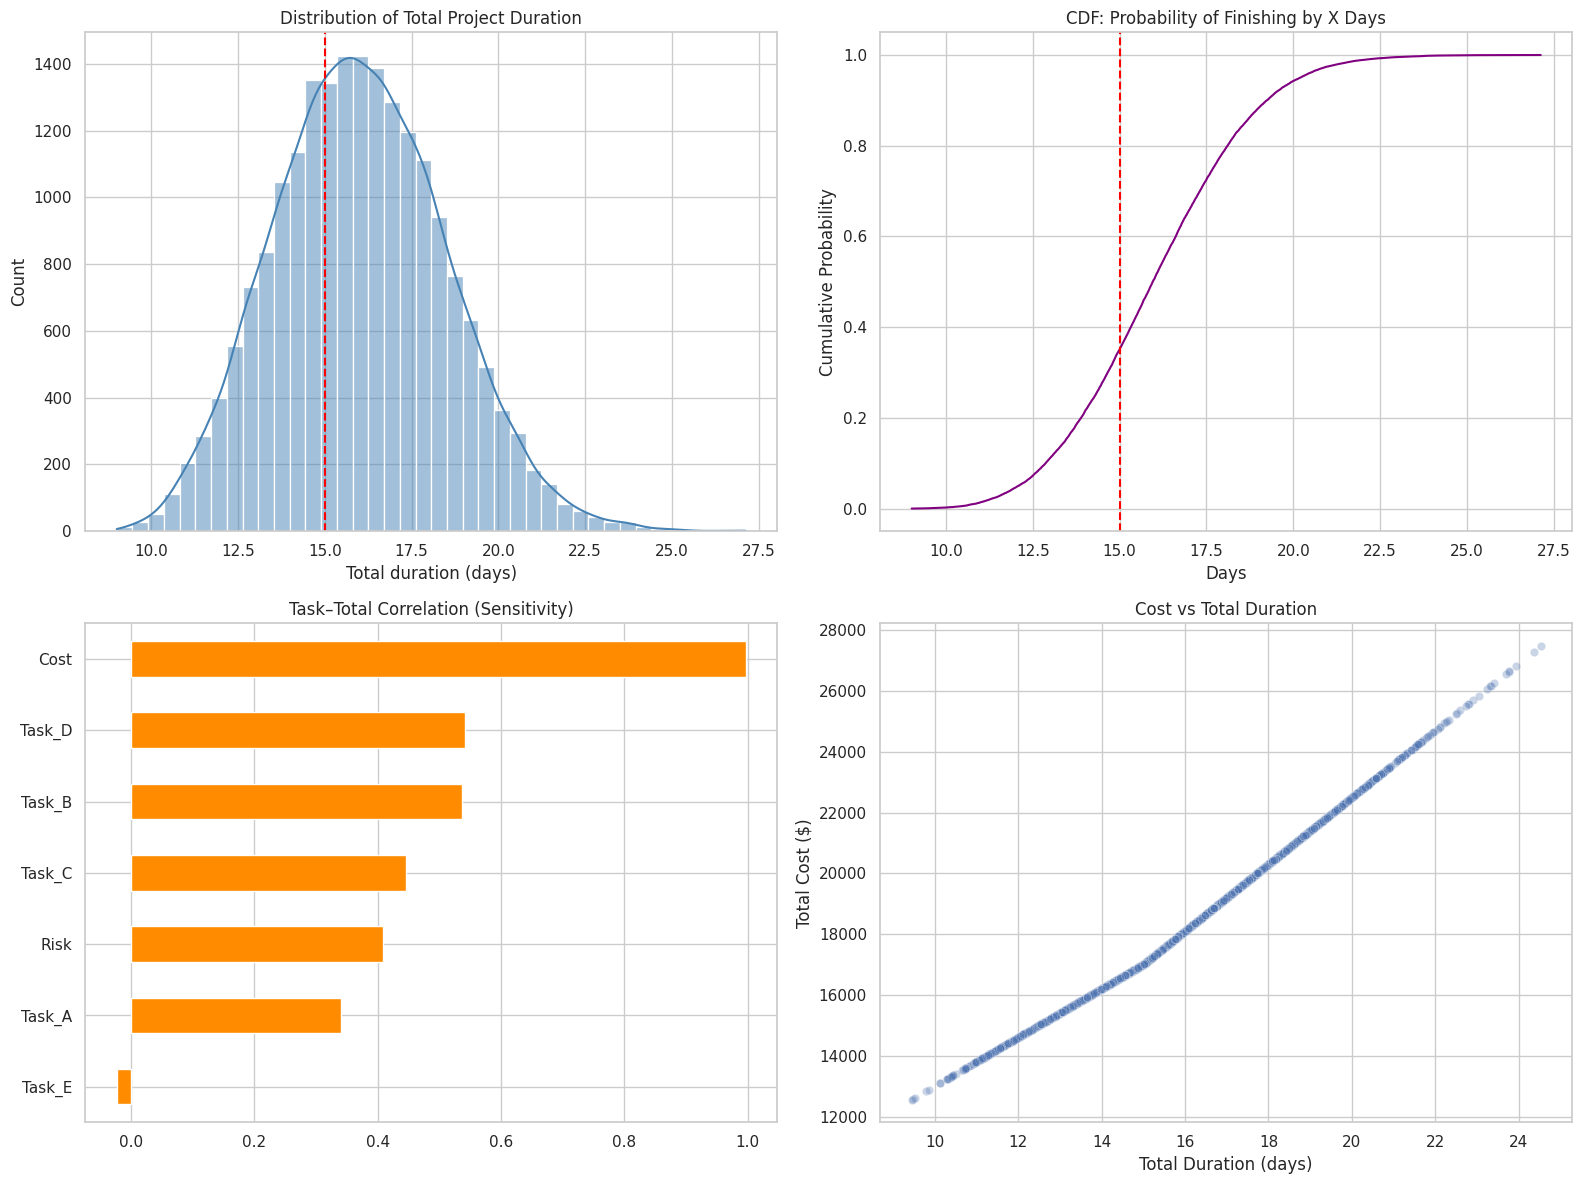

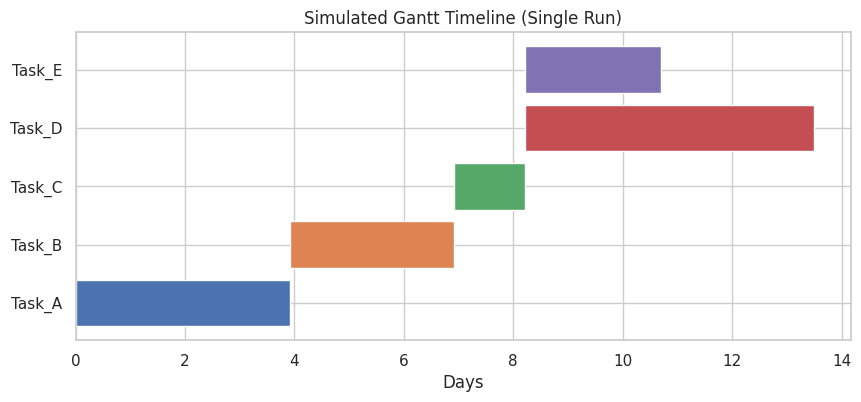

In [4]:
# ============================================================
#  MONTE CARLO PROJECT RISK SIMULATION — TEMPLATE VERSION
#  Clean, modular, and easy to customize
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. SIMULATION SETTINGS
# ------------------------------------------------------------
N = 20000  # number of Monte Carlo runs
rng = np.random.default_rng(42)  # reproducible randomness

# ------------------------------------------------------------
# 2. DEFINE TASK DURATIONS (CUSTOMIZE THESE)
# ------------------------------------------------------------
# Example: Uniform(min, max, N)
A = rng.uniform(2, 5, N)
B = rng.uniform(3, 7, N)
C_base = rng.uniform(1, 4, N)
D = rng.uniform(2, 6, N)
E = rng.uniform(1, 3, N)

# ------------------------------------------------------------
# 3. DEPENDENCIES (CUSTOMIZE AS NEEDED)
# ------------------------------------------------------------
# Example: Task C gets longer if Task B is long
extra_C = 0.3 * np.maximum(B - 5, 0)
C = C_base + extra_C

# ------------------------------------------------------------
# 4. RESOURCE CONSTRAINTS (OPTIONAL)
# ------------------------------------------------------------
# Example: D and E share a resource → delays if both need it
resource_delay = np.maximum(D - E, 0) * 0.2
D_adj = D + resource_delay

# ------------------------------------------------------------
# 5. RISK EVENTS (OPTIONAL)
# ------------------------------------------------------------
# Example risk events with probability + impact
rework = rng.choice([0, 1], size=N, p=[0.90, 0.10]) * rng.uniform(1, 3, N)
supplier_delay = rng.choice([0, 1], size=N, p=[0.95, 0.05]) * rng.uniform(2, 5, N)
outage = rng.choice([0, 1], size=N, p=[0.97, 0.03]) * rng.uniform(1, 2, N)

risk_total = rework + supplier_delay + outage

# ------------------------------------------------------------
# 6. PROJECT STRUCTURE (CUSTOMIZE LOGIC)
# ------------------------------------------------------------
# Sequential: A → B → C
# Parallel: D_adj and E after C
total_time = A + B + C + np.maximum(D_adj, E) + risk_total

# Put everything into a DataFrame
df = pd.DataFrame({
    'Task_A': A,
    'Task_B': B,
    'Task_C': C,
    'Task_D': D_adj,
    'Task_E': E,
    'Risk': risk_total,
    'Total': total_time
})

# ------------------------------------------------------------
# 7. COST MODEL (OPTIONAL)
# ------------------------------------------------------------
base_cost = 5000
cost_per_day = 800
delay_penalty = np.maximum(total_time - 15, 0) * 300

total_cost = base_cost + cost_per_day * total_time + delay_penalty
df['Cost'] = total_cost

# ------------------------------------------------------------
# 8. SENSITIVITY ANALYSIS
# ------------------------------------------------------------
correlations = df.corr()['Total'].drop('Total')

# ------------------------------------------------------------
# 9. SUMMARY STATISTICS
# ------------------------------------------------------------
summary = df['Total'].describe(percentiles=[0.1, 0.5, 0.9, 0.95])

# ------------------------------------------------------------
# 10. PROBABILITY OF FINISHING BY DEADLINE
# ------------------------------------------------------------
deadline = 15
prob_on_time = (df['Total'] <= deadline).mean()

print("Correlation with Total duration:")
print(correlations.sort_values(ascending=False))
print("\nSummary of Total project duration (days):")
print(summary)
print(f"\nProbability of finishing in <= {deadline} days: {prob_on_time:.3f}")

# ------------------------------------------------------------
# 11. DASHBOARD PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Histogram of total duration
sns.histplot(df['Total'], bins=40, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].axvline(deadline, color='red', linestyle='--')
axes[0,0].set_title('Distribution of Total Project Duration')
axes[0,0].set_xlabel('Total duration (days)')

# B. CDF curve
sorted_times = np.sort(df['Total'])
cdf = np.arange(1, N+1) / N
axes[0,1].plot(sorted_times, cdf, color='purple')
axes[0,1].axvline(deadline, color='red', linestyle='--')
axes[0,1].set_title('CDF: Probability of Finishing by X Days')
axes[0,1].set_xlabel('Days')
axes[0,1].set_ylabel('Cumulative Probability')

# C. Sensitivity bar chart
correlations.sort_values().plot(kind='barh', ax=axes[1,0], color='darkorange')
axes[1,0].set_title('Task–Total Correlation (Sensitivity)')

# D. Cost vs Time scatter
sns.scatterplot(x='Total', y='Cost', data=df.sample(3000), ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Cost vs Total Duration')
axes[1,1].set_xlabel('Total Duration (days)')
axes[1,1].set_ylabel('Total Cost ($)')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 12. GANTT TIMELINE FOR ONE SIMULATION
# ------------------------------------------------------------
i = rng.integers(0, N)  # pick a random simulation

timeline = {
    'Task_A': (0, A[i]),
    'Task_B': (A[i], A[i] + B[i]),
    'Task_C': (A[i] + B[i], A[i] + B[i] + C[i]),
    'Task_D': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + D_adj[i]),
    'Task_E': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + E[i])
}

plt.figure(figsize=(10, 4))
for idx, (task, (start, end)) in enumerate(timeline.items()):
    plt.barh(task, end - start, left=start)
plt.title('Simulated Gantt Timeline (Single Run)')
plt.xlabel('Days')
plt.show()

Correlation with Total duration:
Cost      0.996786
Task_D    0.541467
Task_B    0.536052
Task_C    0.445808
Risk      0.409195
Task_A    0.341415
Task_E   -0.022973
Name: Total, dtype: float64

Summary of Total project duration (days):
count    20000.000000
mean        16.027271
std          2.470823
min          9.008893
10%         12.867164
50%         15.950565
90%         19.238065
95%         20.201533
max         27.126327
Name: Total, dtype: float64

Probability of finishing in <= 15 days: 0.351


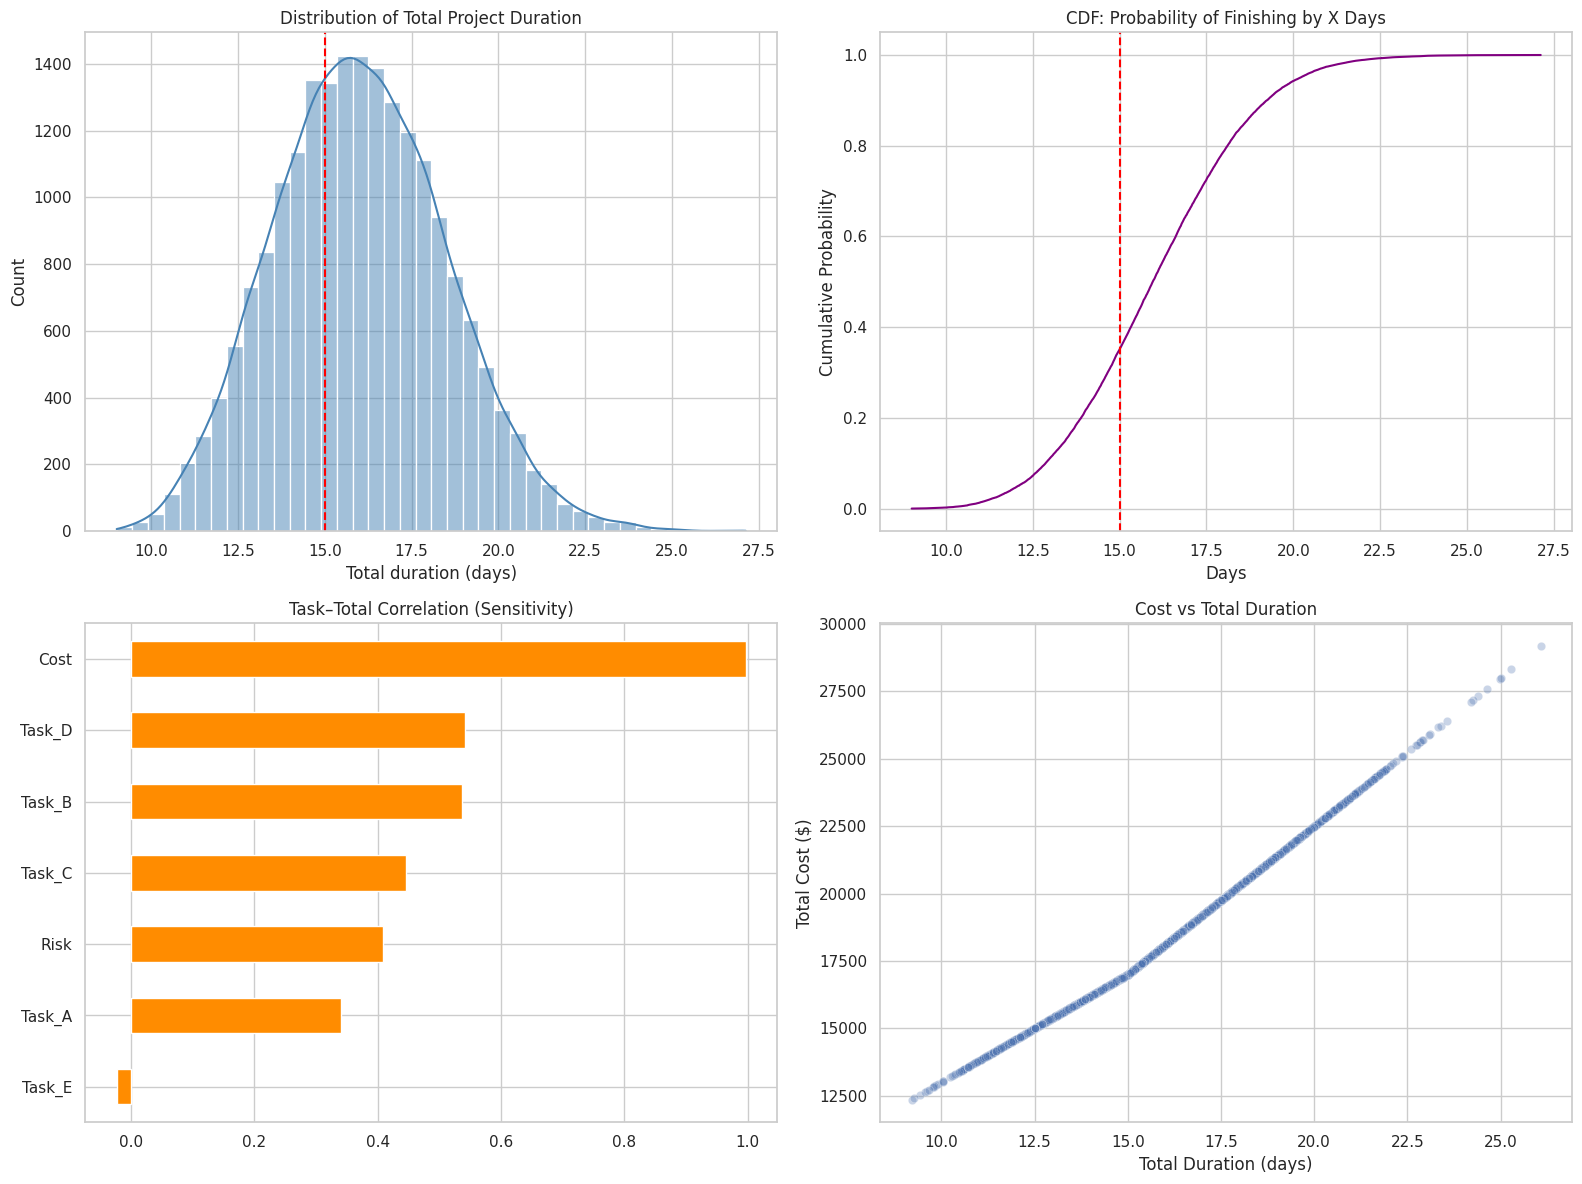

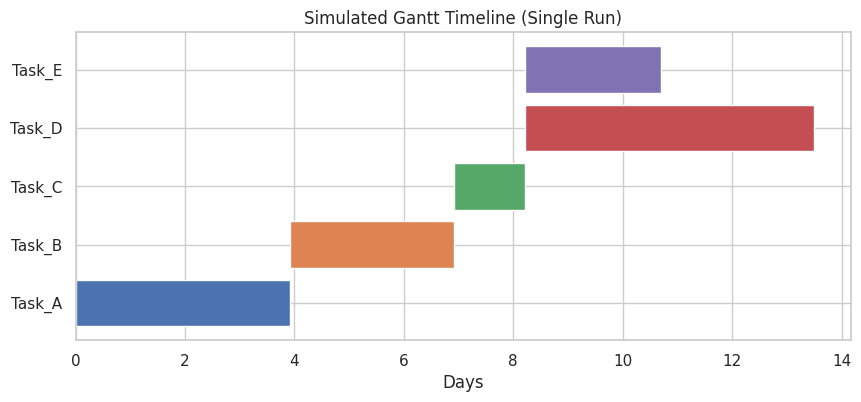

In [5]:
# ============================================================
#  MONTE CARLO PROJECT RISK SIMULATION — TEMPLATE VERSION
#  Clean, modular, and easy to customize
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. SIMULATION SETTINGS
# ------------------------------------------------------------
N = 20000  # number of Monte Carlo runs
rng = np.random.default_rng(42)  # reproducible randomness

# ------------------------------------------------------------
# 2. DEFINE TASK DURATIONS (CUSTOMIZE THESE)
# ------------------------------------------------------------
# Example: Uniform(min, max, N)
A = rng.uniform(2, 5, N)
B = rng.uniform(3, 7, N)
C_base = rng.uniform(1, 4, N)
D = rng.uniform(2, 6, N)
E = rng.uniform(1, 3, N)

# ------------------------------------------------------------
# 3. DEPENDENCIES (CUSTOMIZE AS NEEDED)
# ------------------------------------------------------------
# Example: Task C gets longer if Task B is long
extra_C = 0.3 * np.maximum(B - 5, 0)
C = C_base + extra_C

# ------------------------------------------------------------
# 4. RESOURCE CONSTRAINTS (OPTIONAL)
# ------------------------------------------------------------
# Example: D and E share a resource → delays if both need it
resource_delay = np.maximum(D - E, 0) * 0.2
D_adj = D + resource_delay

# ------------------------------------------------------------
# 5. RISK EVENTS (OPTIONAL)
# ------------------------------------------------------------
# Example risk events with probability + impact
rework = rng.choice([0, 1], size=N, p=[0.90, 0.10]) * rng.uniform(1, 3, N)
supplier_delay = rng.choice([0, 1], size=N, p=[0.95, 0.05]) * rng.uniform(2, 5, N)
outage = rng.choice([0, 1], size=N, p=[0.97, 0.03]) * rng.uniform(1, 2, N)

risk_total = rework + supplier_delay + outage

# ------------------------------------------------------------
# 6. PROJECT STRUCTURE (CUSTOMIZE LOGIC)
# ------------------------------------------------------------
# Sequential: A → B → C
# Parallel: D_adj and E after C
total_time = A + B + C + np.maximum(D_adj, E) + risk_total

# Put everything into a DataFrame
df = pd.DataFrame({
    'Task_A': A,
    'Task_B': B,
    'Task_C': C,
    'Task_D': D_adj,
    'Task_E': E,
    'Risk': risk_total,
    'Total': total_time
})

# ------------------------------------------------------------
# 7. COST MODEL (OPTIONAL)
# ------------------------------------------------------------
base_cost = 5000
cost_per_day = 800
delay_penalty = np.maximum(total_time - 15, 0) * 300

total_cost = base_cost + cost_per_day * total_time + delay_penalty
df['Cost'] = total_cost

# ------------------------------------------------------------
# 8. SENSITIVITY ANALYSIS
# ------------------------------------------------------------
correlations = df.corr()['Total'].drop('Total')

# ------------------------------------------------------------
# 9. SUMMARY STATISTICS
# ------------------------------------------------------------
summary = df['Total'].describe(percentiles=[0.1, 0.5, 0.9, 0.95])

# ------------------------------------------------------------
# 10. PROBABILITY OF FINISHING BY DEADLINE
# ------------------------------------------------------------
deadline = 15
prob_on_time = (df['Total'] <= deadline).mean()

print("Correlation with Total duration:")
print(correlations.sort_values(ascending=False))
print("\nSummary of Total project duration (days):")
print(summary)
print(f"\nProbability of finishing in <= {deadline} days: {prob_on_time:.3f}")

# ------------------------------------------------------------
# 11. DASHBOARD PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Histogram of total duration
sns.histplot(df['Total'], bins=40, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].axvline(deadline, color='red', linestyle='--')
axes[0,0].set_title('Distribution of Total Project Duration')
axes[0,0].set_xlabel('Total duration (days)')

# B. CDF curve
sorted_times = np.sort(df['Total'])
cdf = np.arange(1, N+1) / N
axes[0,1].plot(sorted_times, cdf, color='purple')
axes[0,1].axvline(deadline, color='red', linestyle='--')
axes[0,1].set_title('CDF: Probability of Finishing by X Days')
axes[0,1].set_xlabel('Days')
axes[0,1].set_ylabel('Cumulative Probability')

# C. Sensitivity bar chart
correlations.sort_values().plot(kind='barh', ax=axes[1,0], color='darkorange')
axes[1,0].set_title('Task–Total Correlation (Sensitivity)')

# D. Cost vs Time scatter
sns.scatterplot(x='Total', y='Cost', data=df.sample(3000), ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Cost vs Total Duration')
axes[1,1].set_xlabel('Total Duration (days)')
axes[1,1].set_ylabel('Total Cost ($)')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 12. GANTT TIMELINE FOR ONE SIMULATION
# ------------------------------------------------------------
i = rng.integers(0, N)  # pick a random simulation

timeline = {
    'Task_A': (0, A[i]),
    'Task_B': (A[i], A[i] + B[i]),
    'Task_C': (A[i] + B[i], A[i] + B[i] + C[i]),
    'Task_D': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + D_adj[i]),
    'Task_E': (A[i] + B[i] + C[i], A[i] + B[i] + C[i] + E[i])
}

plt.figure(figsize=(10, 4))
for idx, (task, (start, end)) in enumerate(timeline.items()):
    plt.barh(task, end - start, left=start)
plt.title('Simulated Gantt Timeline (Single Run)')
plt.xlabel('Days')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

rng = np.random.default_rng(42)
N = 20000  # number of simulations

def pert_random(a, m, b, size, rng):
    """
    Draw random samples from a PERT distribution
    defined by optimistic (a), most likely (m), pessimistic (b).
    """
    alpha = 1 + 4 * (m - a) / (b - a)
    beta = 1 + 4 * (b - m) / (b - a)
    return rng.beta(alpha, beta, size=size) * (b - a) + a

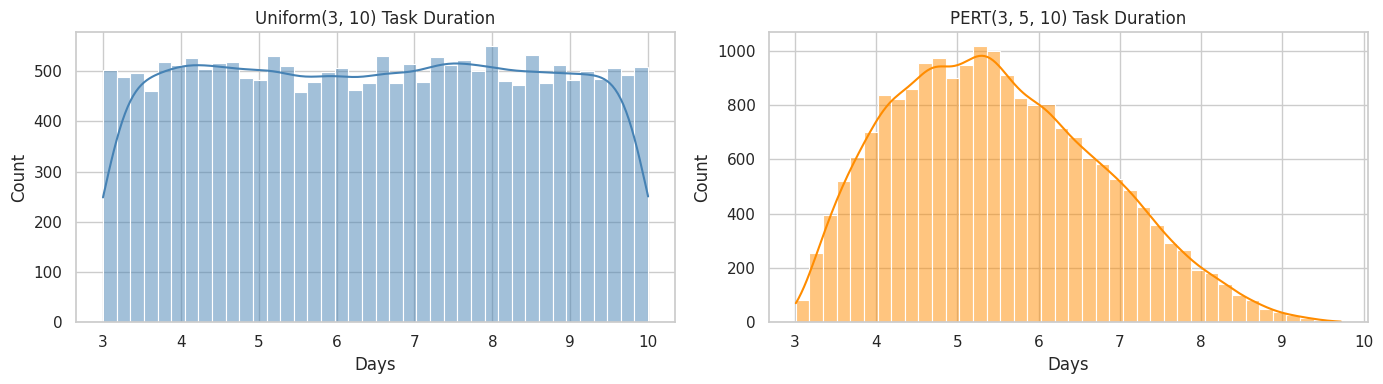

In [7]:
# Uniform version: everything between 3 and 10 equally likely
task_uniform = rng.uniform(3, 10, N)

# PERT version: 3 (opt), 5 (most likely), 10 (pessimistic)
task_pert = pert_random(3, 5, 10, N, rng)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(task_uniform, bins=40, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Uniform(3, 10) Task Duration')
axes[0].set_xlabel('Days')

sns.histplot(task_pert, bins=40, kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('PERT(3, 5, 10) Task Duration')
axes[1].set_xlabel('Days')

plt.tight_layout()
plt.show()

3. Build a PERT‑based project simulation (parallel to your uniform one)
Now we’ll define two versions of the same project:
- One with uniform task durations
- One with PERT task durations
Then we’ll compare total project duration distributions.


In [8]:
N = 20000
rng = np.random.default_rng(42)

# ---------- UNIFORM VERSION ----------
A_u = rng.uniform(2, 5, N)
B_u = rng.uniform(3, 7, N)
C_base_u = rng.uniform(1, 4, N)
D_u = rng.uniform(2, 6, N)
E_u = rng.uniform(1, 3, N)

extra_C_u = 0.3 * np.maximum(B_u - 5, 0)
C_u = C_base_u + extra_C_u

resource_delay_u = np.maximum(D_u - E_u, 0) * 0.2
D_adj_u = D_u + resource_delay_u

rework_u = rng.choice([0, 1], size=N, p=[0.90, 0.10]) * rng.uniform(1, 3, N)
supplier_delay_u = rng.choice([0, 1], size=N, p=[0.95, 0.05]) * rng.uniform(2, 5, N)
outage_u = rng.choice([0, 1], size=N, p=[0.97, 0.03]) * rng.uniform(1, 2, N)
risk_total_u = rework_u + supplier_delay_u + outage_u

total_time_uniform = A_u + B_u + C_u + np.maximum(D_adj_u, E_u) + risk_total_u

# ---------- PERT VERSION ----------
A_p = pert_random(2, 3.5, 5, N, rng)   # opt, most likely, pess
B_p = pert_random(3, 5, 7, N, rng)
C_base_p = pert_random(1, 2, 4, N, rng)
D_p = pert_random(2, 4, 6, N, rng)
E_p = pert_random(1, 1.5, 3, N, rng)

extra_C_p = 0.3 * np.maximum(B_p - 5, 0)
C_p = C_base_p + extra_C_p

resource_delay_p = np.maximum(D_p - E_p, 0) * 0.2
D_adj_p = D_p + resource_delay_p

rework_p = rng.choice([0, 1], size=N, p=[0.90, 0.10]) * pert_random(1, 2, 3, N, rng)
supplier_delay_p = rng.choice([0, 1], size=N, p=[0.95, 0.05]) * pert_random(2, 3, 5, N, rng)
outage_p = rng.choice([0, 1], size=N, p=[0.97, 0.03]) * pert_random(1, 1.5, 2, N, rng)
risk_total_p = rework_p + supplier_delay_p + outage_p

total_time_pert = A_p + B_p + C_p + np.maximum(D_adj_p, E_p) + risk_total_p

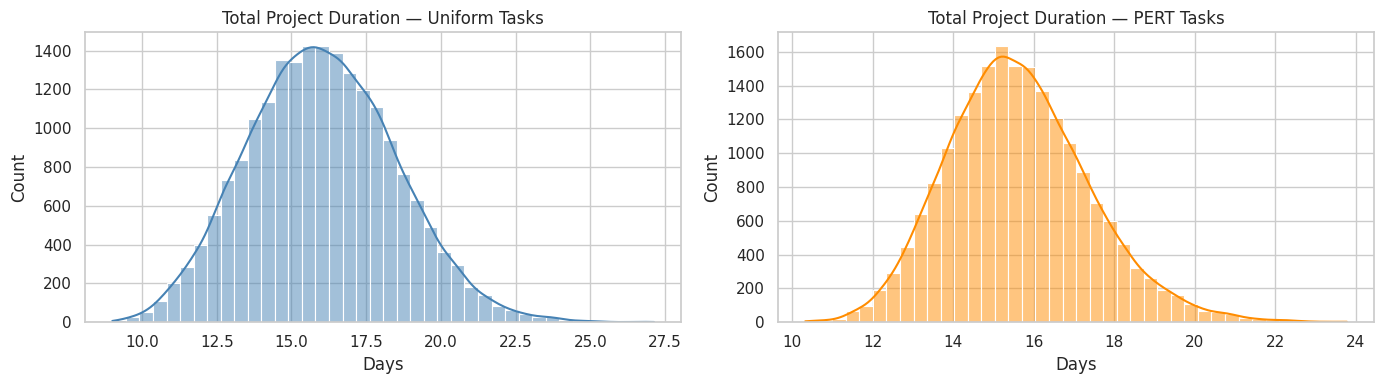

Uniform total duration summary:
count    20000.000000
mean        16.027271
std          2.470823
min          9.008893
50%         15.950565
90%         19.238065
95%         20.201533
max         27.126327
dtype: float64

PERT total duration summary:
count    20000.000000
mean        15.624285
std          1.770431
min         10.319678
50%         15.509937
90%         17.917884
95%         18.720050
max         23.776658
dtype: float64


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(total_time_uniform, bins=40, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Total Project Duration — Uniform Tasks')
axes[0].set_xlabel('Days')

sns.histplot(total_time_pert, bins=40, kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Total Project Duration — PERT Tasks')
axes[1].set_xlabel('Days')

plt.tight_layout()
plt.show()

print("Uniform total duration summary:")
print(pd.Series(total_time_uniform).describe(percentiles=[0.5, 0.9, 0.95]))
print("\nPERT total duration summary:")
print(pd.Series(total_time_pert).describe(percentiles=[0.5, 0.9, 0.95]))

What you’ll likely see:
- PERT version is more “concentrated” around the most likely durations.
- The tails (extreme long durations) may be a bit different—often slightly less wild than uniform.
- Medians and P90/P95 may shift in a way that feels more realistic.

5. How to interpret the difference
In words you could use in a presentation:
- Uniform model:
“We assumed all durations in a range were equally likely. This is simple but not very realistic.”
- PERT model:
“We used optimistic, most likely, and pessimistic estimates for each task. The simulation now reflects that tasks usually take around the most likely duration, with less frequent extremes.”
You’ve just upgraded your model from “rough uncertainty” to “expert‑informed uncertainty.”


Patty, this is a fantastic next step — comparing probabilities of finishing by a deadline under Uniform vs PERT is exactly how analysts show stakeholders why PERT is worth using. And adding a toggle makes your notebook feel like a real interactive tool.
Let’s build this cleanly and clearly.

⭐ PART 1 — Compare probabilities of finishing by a deadline
We’ll assume you already have:
- total_time_uniform
- total_time_pert
from your earlier simulations.
Here’s how to compute and compare probabilities:


In [10]:
deadline = 15  # choose any deadline you want

prob_uniform = (total_time_uniform <= deadline).mean()
prob_pert = (total_time_pert <= deadline).mean()

print(f"Probability of finishing by {deadline} days (Uniform): {prob_uniform:.3f}")
print(f"Probability of finishing by {deadline} days (PERT):    {prob_pert:.3f}")

Probability of finishing by 15 days (Uniform): 0.351
Probability of finishing by 15 days (PERT):    0.379


⭐ What you’ll typically see:
- Uniform tends to give a wider distribution → lower probability of finishing early
- PERT tends to cluster around the “most likely” → often slightly higher probability of finishing by the deadline
This is why PERT is preferred in project management.


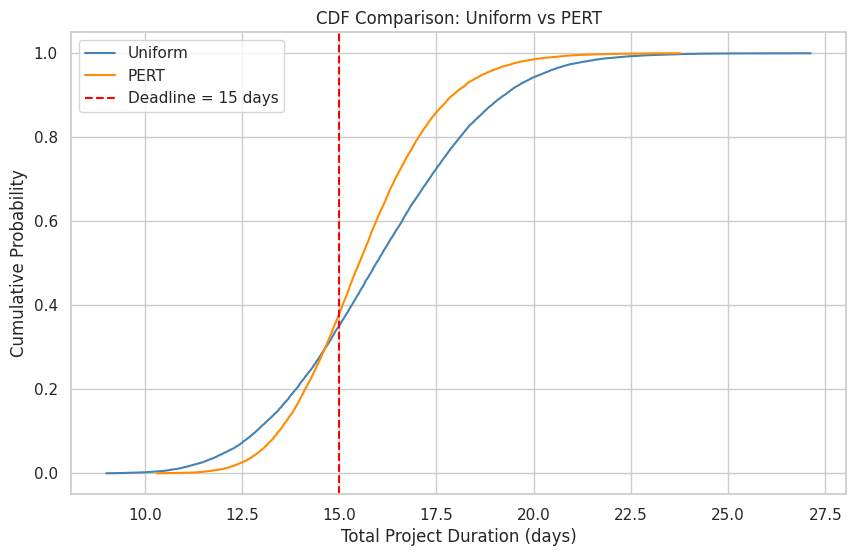

In [11]:
# Sort both distributions
u_sorted = np.sort(total_time_uniform)
p_sorted = np.sort(total_time_pert)

cdf = np.arange(1, N+1) / N

plt.figure(figsize=(10, 6))
plt.plot(u_sorted, cdf, label='Uniform', color='steelblue')
plt.plot(p_sorted, cdf, label='PERT', color='darkorange')

plt.axvline(deadline, color='red', linestyle='--', label=f'Deadline = {deadline} days')

plt.title('CDF Comparison: Uniform vs PERT')
plt.xlabel('Total Project Duration (days)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

 What this plot tells you:
- Where the curves cross the deadline line
- Which distribution is “tighter”
- How much earlier PERT reaches high confidence levels (P80, P90, etc.)

⭐ PART 3 — Add a toggle to switch between Uniform and PERT
This is where your notebook becomes interactive and fun.
We’ll use a simple Python variable called mode


In [12]:
mode = "PERT"   # change to "UNIFORM" to switch

In [13]:
if mode == "UNIFORM":
    A = rng.uniform(2, 5, N)
    B = rng.uniform(3, 7, N)
    C_base = rng.uniform(1, 4, N)
    D = rng.uniform(2, 6, N)
    E = rng.uniform(1, 3, N)

elif mode == "PERT":
    A = pert_random(2, 3.5, 5, N, rng)
    B = pert_random(3, 5, 7, N, rng)
    C_base = pert_random(1, 2, 4, N, rng)
    D = pert_random(2, 4, 6, N, rng)
    E = pert_random(1, 1.5, 3, N, rng)

else:
    raise ValueError("mode must be 'UNIFORM' or 'PERT'")